# Training example

In [1]:
# load all libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Load data

In [2]:
# list data folder
!ls ZH/

cHW-003.txt  cHW+003.txt  plots.pdf  SM.txt  Zbb.txt


In [3]:
# load data-sets
sm = pd.read_csv('ZH/SM.txt')#.astype(np.float16)
bsm = pd.read_csv('ZH/cHW+003.txt')#.astype(np.float16)
bkg = pd.read_csv('ZH/Zbb.txt')#.astype(np.float16)



In [4]:
# clean-up column names
sm.columns = map(lambda x: x.replace(" ","").replace('#',''),sm.columns)
bsm.columns = map(lambda x: x.replace(" ","").replace('#',''),bsm.columns)
bkg.columns = map(lambda x: x.replace(" ","").replace('#',''),bkg.columns)


In [5]:
sm.columns

Index([u'wgt', u'pTZ', u'MVH', u'yZ', u'yH', u'etaZ', u'etaH', u'pTb1',
       u'pTb2', u'pTl1', u'pTl2', u'etab1', u'etab2', u'etal1', u'etal2',
       u'Mbb', u'nj_pT20'],
      dtype='object')

## Prepare for training

In [6]:
# define labels: 0: BSM, 1: SM, 2:background
bsm['label'] = np.zeros((bsm.shape[0],1))
sm['label'] = np.ones((sm.shape[0],1))
bkg['label'] = np.ones((bkg.shape[0],1))*2


In [7]:
# input features
features = [ u'pTZ', u'MVH', u'yZ', u'yH', u'etaZ', u'etaH', u'pTb1',
       u'pTb2', u'pTl1', u'pTl2', u'etab1', u'etab2', u'etal1', u'etal2',
       u'Mbb' ]


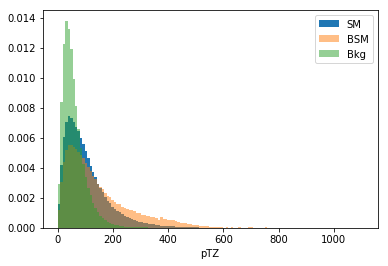

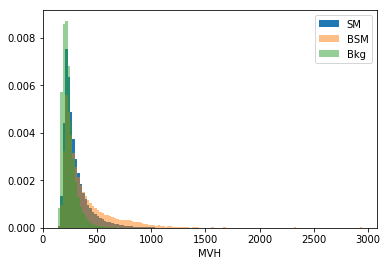

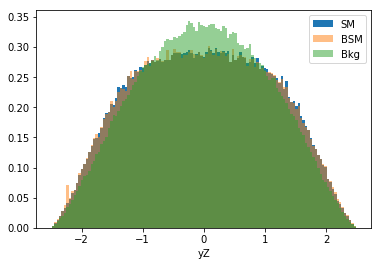

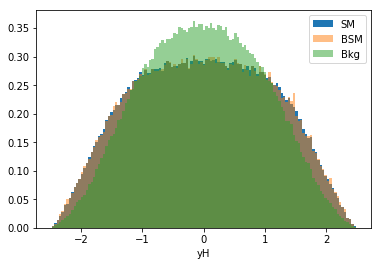

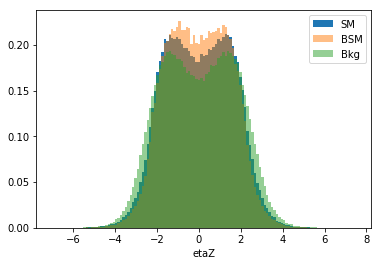

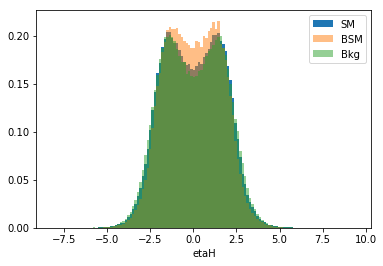

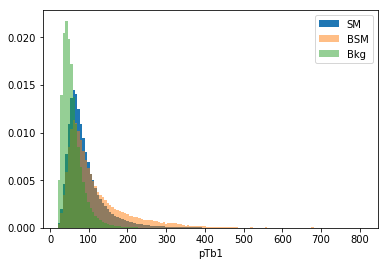

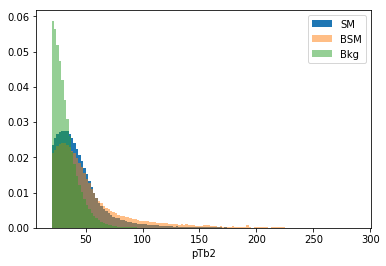

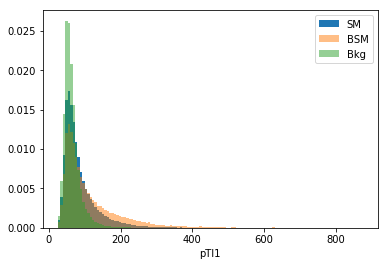

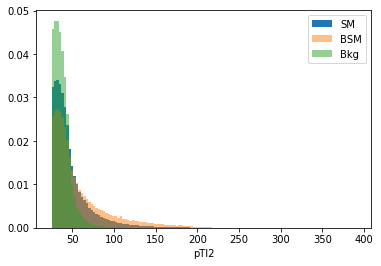

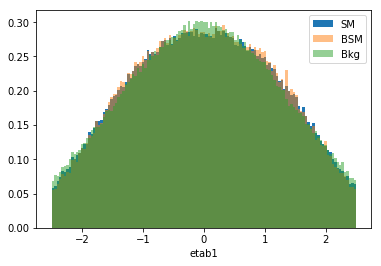

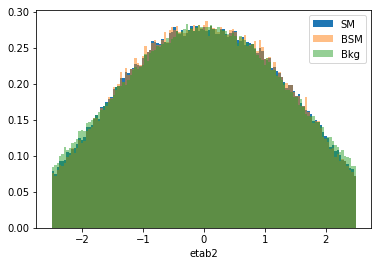

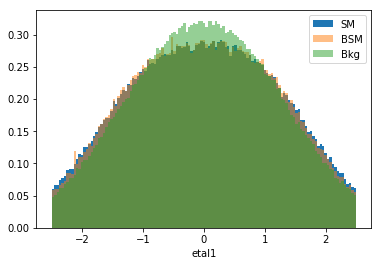

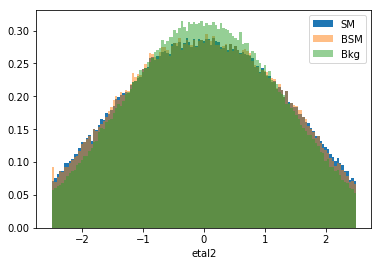

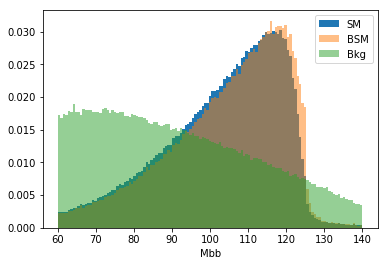

In [8]:
# plot input features
for feature in features:
    _, bins, _ = plt.hist(sm[feature],bins=125,label='SM',weights=sm.wgt,normed=True)
    plt.hist(bsm[feature],bins=bins,label='BSM',weights=bsm.wgt,alpha=0.5,normed=True)
    plt.hist(bkg[feature],bins=bins,label='Bkg',weights=bkg.wgt,alpha=0.5,normed=True)
    plt.xlabel(feature)
    plt.legend()
    plt.show()

In [9]:
# normalize weights
ref = sm.shape[0]
sm['wgt'] /= sm['wgt'].sum() / ref
bsm['wgt'] /= bsm['wgt'].sum() / ref
bkg['wgt'] /= bkg['wgt'].sum() / ref

In [10]:
# Merge data-sets into a single one
df = pd.concat([sm,bsm,bkg])

In [11]:
print('Full dataset has shape ',df.shape)

('Full dataset has shape ', (1052966, 18))


In [12]:
df.groupby('label')['wgt'].mean()

label
0.0    0.999752
1.0    1.000000
2.0    0.898227
Name: wgt, dtype: float64

In [13]:
# shuffle data-set
seed = 56789
np.random.seed(seed)
random_index = np.array(range(df.shape[0]))

np.random.shuffle(random_index)

df['random_index'] = random_index

df.set_index('random_index',inplace=True)

df.sort_index(inplace=True)

In [14]:
# get featrues and target
X = df[features].values#.astype(np.float16)
y = df['label'].values#.astype(np.float16)
w = df['wgt'].values#.astype(np.float16)

In [15]:
import gc

del sm
del bsm
del bkg
del df




In [16]:
gc.collect()

111175

## Train BDT

In [17]:
from sklearn import ensemble


In [18]:
from sklearn.model_selection import train_test_split


In [19]:
# split into train and test sample
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,random_state=123456)

print(X_train.shape)

(789724, 15)


In [20]:
# possibly limit number of training entries
## nentries = 50000
nentries = -1
X_train = X_train[:nentries]
y_train = y_train[:nentries]
w_train = w_train[:nentries]

In [21]:
del X
del y
gc.collect()

0

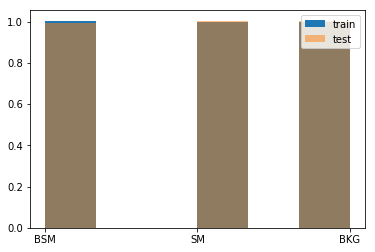

In [22]:
plt.hist(y_train,label='train',normed=True,bins=6,weights=w_train)
plt.hist(y_test,label='test',normed=True,bins=6,alpha=0.5,weights=w_test)
plt.xticks(range(3),('BSM','SM','BKG'))
# plt.yscale('log')
plt.legend()

In [23]:
# instantiate classifier
from xgboost import XGBClassifier

# clf = ensemble.GradientBoostingClassifier(max_depth=10,n_estimators=300,subsample=0.8,
#                                         learning_rate=0.05)
clf = XGBClassifier(max_depth=10,n_estimators=600,subsample=0.8,
                                        learning_rate=0.05,nthread=5)


/mnt/t3nfs01/data01/shome/musella/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [24]:
# train it
%time clf.fit(X_train,y_train,w_train)

CPU times: user 2h 42min 54s, sys: 5min 43s, total: 2h 48min 38s
Wall time: 33min 47s


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=600, nthread=5,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

## Apply BDT

In [25]:
%time y_pred = clf.predict_proba(X_test)

CPU times: user 2min 5s, sys: 343 ms, total: 2min 6s
Wall time: 43.9 s


In [26]:
bsm_pred = y_pred[ (y_test== 0).ravel() ]
sm_pred = y_pred[ (y_test== 1).ravel() ]
bkg_pred = y_pred[ (y_test== 2).ravel() ]

bsm_w = w_test[ (y_test== 0).ravel()]
sm_w = w_test[ (y_test== 1).ravel()]
bkg_w = w_test[ (y_test== 2).ravel()]


In [27]:
# X_test.shape, w_test.shape, y_pred.shape
bsm_pred.shape, bsm_w.shape

((84345, 3), (84345,))

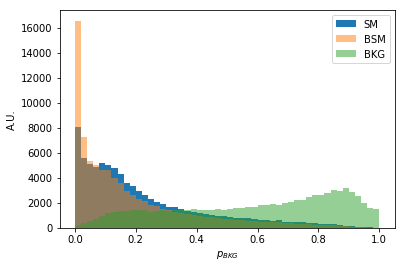

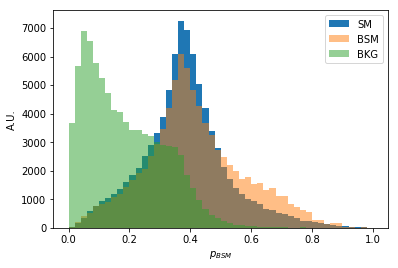

In [28]:
for iprob,label in (2,'$p_{BKG}$'),(0,'$p_{BSM}$'):
    plt.hist(sm_pred[:,iprob].ravel(),weights=sm_w.ravel(),range=[0,1],bins=50,label='SM')
    plt.hist(bsm_pred[:,iprob].ravel(),weights=bsm_w.ravel(),range=[0,1],bins=50,alpha=0.5,label='BSM');
    plt.hist(bkg_pred[:,iprob].ravel(),weights=bkg_w.ravel(),range=[0,1],bins=50,alpha=0.5,label='BKG');
    plt.xlabel('%s' % label)
    plt.ylabel('A.U.')
    plt.legend()
    plt.show()


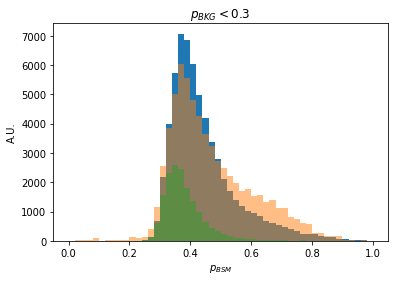

In [29]:
plt.hist(sm_pred[:,0],weights=sm_w*(sm_pred[:,2]<0.3),range=[0,1],bins=50,label='SM')
plt.hist(bsm_pred[:,0],weights=bsm_w*(bsm_pred[:,2]<0.3),range=[0,1],bins=50,alpha=0.5,label='BSM');
plt.hist(bkg_pred[:,0],weights=bkg_w*(bkg_pred[:,2]<0.3),range=[0,1],bins=50,alpha=0.5,label='BKG');
plt.title('$p_{BKG} < 0.3$')
plt.xlabel('$p_{BSM}$')
plt.ylabel('A.U.')

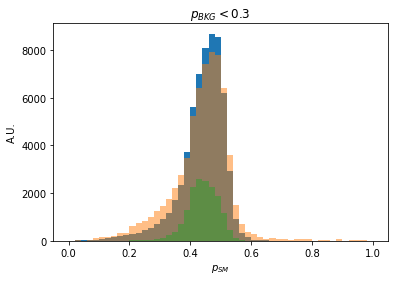

In [31]:
plt.hist(sm_pred[:,1],weights=sm_w*(sm_pred[:,2]<0.3),range=[0,1],bins=50,label='SM')
plt.hist(bsm_pred[:,1],weights=bsm_w*(bsm_pred[:,2]<0.3),range=[0,1],bins=50,alpha=0.5,label='BSM');
plt.hist(bkg_pred[:,1],weights=bkg_w*(bkg_pred[:,2]<0.3),range=[0,1],bins=50,alpha=0.5,label='BKG');
plt.title('$p_{BKG} < 0.3$')
plt.xlabel('$p_{SM}$')
plt.ylabel('A.U.')

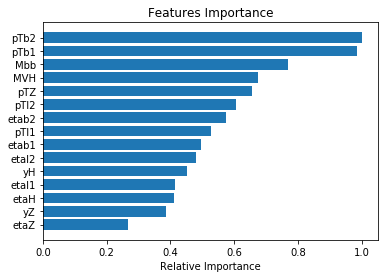

In [30]:
feature_importance = clf.feature_importances_
feature_importance /= feature_importance.max()
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Features Importance')
plt.show()